In [1]:
# The default Zbedrock depth is too large for some basins. What will happen if this parameter is reduced?
# The changes are made based on existing LHS iteration-0 results

In [43]:
import pandas as pd
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt

In [44]:
# find basins to change
files = glob.glob('/glade/work/guoqiang/CTSM_CAMELS/data_paramcailb/ParamCalib_basinparam_*.csv')

z = []
for f in files:
    df=pd.read_csv(f)
    if 'zbedrock' in df['Parameter'].values:
        d = df[df['Parameter']=='zbedrock']['Default'].values[0]
        z.append(d)
    else:
        z.append(-999)

z = np.array(z)

target basins 53


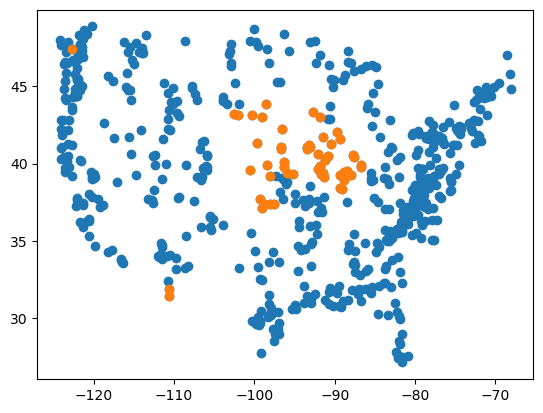

In [45]:
index = np.where(z>5)[0]
print('target basins', len(index))
sel_hruid = [int(files[s].split('basinparam_')[1].split('.csv')[0]) for s in index]

# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)

sel_id = [np.where(df_info['hru_id'].values == h)[0][0] for h in sel_hruid]
sel_id = np.sort(np.array(sel_id))

# plot locations
lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values
plt.scatter(lon, lat)
plt.scatter(lon[sel_id], lat[sel_id])
plt.show()

# create new LHS params

In [46]:
# code check
z2 = []
for basin in sel_id:
    infile = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin}_MOASMOcalib/param_sets/paramset_iter0_trial0.pkl'
    dfb = pd.read_pickle(infile)
    z2.append(dfb[dfb['Parameter']=='zbedrock']['Value'].values[0][0])
print(np.nanmin(z2))

5.920188008750286


In [53]:
lb = 0.3
up = 6

for basin in sel_id:

    allp = []
    for i in range(400):
        infile = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin}_MOASMOcalib/param_sets/paramset_iter0_trial{i}.pkl'
        outpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin}_MOASMOcalib/param_sets_LowZbedrock'
        os.makedirs(outpath, exist_ok=True)
        outfile = f'{outpath}/paramset_iter0_trial{i}.pkl'
        if os.path.isfile(outfile):
            dfb = pd.read_pickle(infile)

            # if i > 0:
            if True:
                Lower = dfb[dfb['Parameter']=='zbedrock']['Lower'].values[0]
                Upper = dfb[dfb['Parameter']=='zbedrock']['Upper'].values[0]
                param_values  = dfb[dfb['Parameter']=='zbedrock']['Value'].values[0]    
                new_param_values = (param_values - Lower) / (Upper - Lower) * (up - lb) + lb
                dfb.loc[dfb['Parameter'] == 'zbedrock', 'Value'] = [new_param_values]
                allp.append(new_param_values)

            dfb.to_pickle(outfile)


In [49]:
# create submission scripts

for basin in sel_id:

    infile = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin}_MOASMOcalib/run_model/iter0/commands_run_iter0.txt'
    with open(infile, 'r') as f:
        lines = f.readlines()

    newlines = []
    for l in lines:
        new_command = l
        new_command = new_command.replace('ctsm_outputs', 'ctsm_outputs_LowZbedrock')
        new_command = new_command.replace('param_sets', 'param_sets_LowZbedrock')
        newlines.append(new_command)

    outpath =  f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin}_MOASMOcalib/run_model_LowZbedrock/iter0'
    os.makedirs(outpath, exist_ok=True)
    outfile = f'{outpath}/commands_run_iter0.txt'
    with open(outfile, 'w') as f:
        for l in newlines:
            f.write(l)
            # break
            


In [50]:
iter = 0
basin_on_one_node = 3
print('Proecssing iteration', iter)
print('basin_on_one_node', basin_on_one_node)


suffix = 'LowZbedrock'

inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange'
outpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/run_model_mpiserial_{suffix}/iter{iter}'
os.makedirs(outpath, exist_ok=True)

basins = [f'level1_{i}' for i in sel_id]
bnum = len(basins)

nbatch = int(bnum/basin_on_one_node) + 1

cpu_per_node = 128

jobparams = [ "#PBS -N MOAcalib", "#PBS -q main", 
              "#PBS -l select=1:ncpus=128", "#PBS -l walltime=12:00:00", 
              "#PBS -l job_priority=economy",
              "#PBS -A P08010000",
             "\n",
              "module load conda nco cdo",
             "conda activate npl-2024a-tgq",
             "\n",
            ]

for i in range(nbatch):
    bstart = i*basin_on_one_node
    bend = (i+1)*basin_on_one_node
    if bend>bnum:
        bend = bnum

    outpathi = f'{outpath}/batch{i}'
    os.makedirs(outpathi, exist_ok=True)
    
    # generate command line file
    newcommands = []
    for j in range(bstart, bend):
        infileij = f'{inpath}/{basins[j]}_MOASMOcalib/run_model_{suffix}/iter{iter}/commands_run_iter{iter}.txt'

        with open(infileij, 'r') as f:
            linesj = f.readlines()
        for l in linesj:
            l = l.strip().split(' ')
            newcommands.append(' '.join(l[:-1]))

    outfile_newcom = f'{outpathi}/batch_{i}.txt'
    with open(outfile_newcom, 'w') as f:
        for l in newcommands:
            _ = f.write(l+'\n')

    # generate submission list
    filesub = f'{outpathi}/submission.sh'
    with open(filesub, 'w') as f:
        for l in jobparams:
            _ = f.write(l+'\n')
        command = f"parallel -j {cpu_per_node} < {outfile_newcom}"
        _ = f.write(command+'\n')


Proecssing iteration 0
basin_on_one_node 100
